In [1]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
hourly = pd.read_csv('Raw_Data.csv')

In [3]:
hourly.head(3)

,Timestamp,PM2.5 (µg/m³),PM10 (µg/m³),NO (µg/m³),NO2 (µg/m³),NOx (ppb),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),...,MP-Xylene (µg/m³),AT (°C),RH (%),WS (m/s),WD (deg),RF (mm),TOT-RF (mm),SR (W/mt2),BP (mmHg),VWS (m/s)
0,2024-01-01 00:00:00,37.90,83.74,5.01,18.67,21.33,12.29,7.39,0.56,28.69,...,0.82,20.40,77.26,0.58,124.91,0.0,0.0,48.64,852.18,-0.08
1,2024-01-01 01:00:00,46.54,88.74,5.14,18.57,21.32,12.30,7.15,0.58,28.86,...,0.82,20.02,79.38,0.61,134.39,0.0,0.0,48.55,853.68,-0.08
2,2024-01-01 02:00:00,43.62,89.61,4.85,18.08,20.44,11.98,7.19,0.53,27.29,...,0.82,19.61,81.86,0.65,118.38,0.0,0.0,48.54,855.35,-0.08


In [4]:
hourly.columns


Index(['Timestamp', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO (µg/m³)',
       'NO2 (µg/m³)', 'NOx (ppb)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)',
       'Ozone (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)',
       'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)',
       'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)',
       'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)'],
      dtype='object')

In [5]:
hourly = hourly.drop(['NO (µg/m³)','NOx (ppb)', 'NH3 (µg/m³)', 'Benzene (µg/m³)', 'Toluene (µg/m³)', 'Xylene (µg/m³)',
       'O Xylene (µg/m³)', 'Eth-Benzene (µg/m³)', 'MP-Xylene (µg/m³)',
       'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'RF (mm)', 'TOT-RF (mm)',
       'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)'], axis = 1)

In [6]:
hourly.columns

Index(['Timestamp', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)',
       'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)'],
      dtype='object')

In [7]:
hourly.isnull().sum()

Timestamp        0
PM2.5 (µg/m³)    0
PM10 (µg/m³)     0
NO2 (µg/m³)      0
SO2 (µg/m³)      0
CO (mg/m³)       0
Ozone (µg/m³)    0
dtype: int64

In [8]:
hourly.rename(
    columns={
        'Timestamp':'date',
        'PM2.5 (µg/m³)': 'pm25',
        'PM10 (µg/m³)': 'pm10',
        'NO2 (µg/m³)': 'no2',
        'SO2 (µg/m³)': 'so2',
        'CO (mg/m³)': 'co',
        'Ozone (µg/m³)': 'o3'
    },
    inplace=True
)

In [9]:
hourly.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3'], dtype='object')

In [10]:
hourly.dtypes

date     object
pm25    float64
pm10    float64
no2     float64
so2     float64
co      float64
o3      float64
dtype: object

In [11]:
hourly['date'] = pd.to_datetime(hourly['date'])

In [12]:
hourly = hourly.sort_values('date')

In [13]:
hourly['CO_8hr_avg'] = (
    hourly
    .groupby(hourly['date'].dt.date)['co']
    .rolling(window=8, min_periods=8)
    .mean()
    .reset_index(level=0, drop=True)
)

In [14]:
hourly['O3_8hr_avg'] = (
    hourly
    .groupby(hourly['date'].dt.date)['o3']
    .rolling(window=8, min_periods=8)
    .mean()
    .reset_index(level=0, drop=True)
)

In [15]:
hourly.tail(3)

,date,pm25,pm10,no2,so2,co,o3,CO_8hr_avg,O3_8hr_avg
8781,2024-12-31 21:00:00,42.65,81.93,23.20,9.65,0.71,24.92,0.68125,25.69750
8782,2024-12-31 22:00:00,45.91,84.68,22.75,9.61,0.68,24.88,0.68625,25.44625
8783,2024-12-31 23:00:00,44.51,85.85,22.28,9.36,0.69,26.39,0.69500,25.40375


In [16]:
daily = (
    hourly
    .assign(date = hourly['date'].dt.floor('D'))
    .groupby('date', as_index=False)
    .agg({
        'pm25': 'mean',
        'pm10': 'mean',
        'no2' : 'mean',
        'so2' : 'mean',
        'CO_8hr_avg': 'max',   # 🔑 key AQI rule
        'O3_8hr_avg': 'max'    # 🔑 key AQI rule
    })
)

In [17]:
daily.head()

,date,pm25,pm10,no2,so2,CO_8hr_avg,O3_8hr_avg
0,2024-01-01,41.995417,87.773750,18.067083,7.955417,0.6900,43.71500
1,2024-01-02,44.888333,95.900000,18.044583,7.477083,0.7375,41.10375
2,2024-01-03,43.796667,96.146667,18.103333,7.735833,0.6750,42.69875
3,2024-01-04,47.991250,110.063333,18.282917,7.770000,0.8225,36.60750
4,2024-01-05,38.072083,87.127500,17.626250,7.555833,0.7375,35.74375


In [18]:
pm25_bp = [
    (0, 30, 0, 50),
    (31, 60, 51, 100),
    (61, 90, 101, 200),
    (91, 120, 201, 300),
    (121, 250, 301, 400),
    (251, 500, 401, 500)
]

In [19]:
def calc_aqi(c,b_lo,b_hi,i_lo,i_hi):
    return ((i_hi - i_lo) / (b_hi - b_lo)) * (c - b_lo) + i_lo

In [21]:
def pollutant_aqi(conc, breakpoint):
    for b_lo,b_hi,i_lo,i_hi in breakpoint:
        if b_lo <= conc <= b_hi:
            return calc_aqi(conc ,b_lo,b_hi,i_lo,i_hi)
    return np.nan

In [22]:
daily["aqi_pm25"] = daily["pm25"].apply(lambda x : pollutant_aqi(round(x) , pm25_bp ))

In [23]:
pm10_bp = [
    (0, 50, 0, 50),
    (51, 100, 51, 100),
    (101, 250, 101, 200),
    (251, 350, 201, 300),
    (351, 430, 301, 400),
    (431, 600, 401, 500)
]

In [24]:
daily["aqi_pm10"] = daily["pm10"].apply(lambda x : pollutant_aqi(round(x) , pm10_bp ))

In [25]:
no2_bp = [
    (0, 40, 0, 50),
    (41, 80, 51, 100),
    (81, 180, 101, 200),
    (181, 280, 201, 300),
    (281, 400, 301, 400),
    (401, 1000, 401, 500)
]

In [26]:
daily["aqi_no2"] = daily["no2"].apply(lambda x : pollutant_aqi(round(x) , no2_bp ))

In [27]:
so2_bp = [
    (0, 40, 0, 50),
    (41, 80, 51, 100),
    (81, 380, 101, 200),
    (381, 800, 201, 300),
    (801, 1600, 301, 400),
    (1601, 2000, 401, 500)
]


In [28]:
daily["aqi_so2"] = daily["so2"].apply(lambda x : pollutant_aqi(round(x) , so2_bp ))

In [29]:
co_bp = [
    (0.0, 1.0, 0, 50),
    (1.1, 2.0, 51, 100),
    (2.1, 10.0, 101, 200),
    (10.1, 17.0, 201, 300),
    (17.1, 34.0, 301, 400),
    (34.1, 50.0, 401, 500)
]

In [30]:
daily["aqi_co"] = daily["CO_8hr_avg"].apply(lambda x : pollutant_aqi(round(x,2) , co_bp ))

In [31]:
o3_bp = [
    (0, 50, 0, 50),
    (51, 100, 51, 100),
    (101, 168, 101, 200),
    (169, 208, 201, 300),
    (209, 748, 301, 400),
    (749, 1000, 401, 500)
]

In [32]:
daily["aqi_o3"] = daily["O3_8hr_avg"].apply(lambda x : pollutant_aqi(round(x) , o3_bp ))

In [33]:
daily.head()

,date,pm25,pm10,no2,so2,CO_8hr_avg,O3_8hr_avg,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3
0,2024-01-01,41.995417,87.773750,18.067083,7.955417,0.6900,43.71500,69.586207,88.000000,22.5,10.00,34.5,44.0
1,2024-01-02,44.888333,95.900000,18.044583,7.477083,0.7375,41.10375,74.655172,96.000000,22.5,8.75,37.0,41.0
2,2024-01-03,43.796667,96.146667,18.103333,7.735833,0.6750,42.69875,72.965517,96.000000,22.5,10.00,34.0,43.0
3,2024-01-04,47.991250,110.063333,18.282917,7.770000,0.8225,36.60750,79.724138,106.979866,22.5,10.00,41.0,37.0
4,2024-01-05,38.072083,87.127500,17.626250,7.555833,0.7375,35.74375,62.827586,87.000000,22.5,10.00,37.0,36.0


In [34]:
daily = daily.rename(columns={
    'CO_8hr_avg': 'co',
    'O3_8hr_avg': 'o3'
})

In [35]:
daily.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3', 'aqi_pm25',
       'aqi_pm10', 'aqi_no2', 'aqi_so2', 'aqi_co', 'aqi_o3'],
      dtype='object')

In [37]:
aqi_cols = ['aqi_pm25','aqi_pm10', 'aqi_no2', 'aqi_so2', 'aqi_co', 'aqi_o3']
daily['final_aqi'] = daily[aqi_cols].max(axis =1)

In [38]:
daily.head()

,date,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3,final_aqi
0,2024-01-01,41.995417,87.773750,18.067083,7.955417,0.6900,43.71500,69.586207,88.000000,22.5,10.00,34.5,44.0,88.000000
1,2024-01-02,44.888333,95.900000,18.044583,7.477083,0.7375,41.10375,74.655172,96.000000,22.5,8.75,37.0,41.0,96.000000
2,2024-01-03,43.796667,96.146667,18.103333,7.735833,0.6750,42.69875,72.965517,96.000000,22.5,10.00,34.0,43.0,96.000000
3,2024-01-04,47.991250,110.063333,18.282917,7.770000,0.8225,36.60750,79.724138,106.979866,22.5,10.00,41.0,37.0,106.979866
4,2024-01-05,38.072083,87.127500,17.626250,7.555833,0.7375,35.74375,62.827586,87.000000,22.5,10.00,37.0,36.0,87.000000


In [39]:
all_cols = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3',
            'aqi_pm25', 'aqi_pm10', 'aqi_no2', 'aqi_so2', 'aqi_co', 'aqi_o3',
            'final_aqi']
daily[all_cols] = daily[all_cols].round(2)

,date,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3,final_aqi
0,2024-01-01,42.00,87.77,18.07,7.96,0.69,43.72,69.59,88.00,22.5,10.00,34.5,44.0,88.00
1,2024-01-02,44.89,95.90,18.04,7.48,0.74,41.10,74.66,96.00,22.5,8.75,37.0,41.0,96.00
2,2024-01-03,43.80,96.15,18.10,7.74,0.68,42.70,72.97,96.00,22.5,10.00,34.0,43.0,96.00
3,2024-01-04,47.99,110.06,18.28,7.77,0.82,36.61,79.72,106.98,22.5,10.00,41.0,37.0,106.98
4,2024-01-05,38.07,87.13,17.63,7.56,0.74,35.74,62.83,87.00,22.5,10.00,37.0,36.0,87.00


In [41]:
category_bp = [
    ("Good", 0, 50),
    ("Satisfactory", 51, 100),
    ("Moderate", 101, 200),
    ("Poor", 201, 300),
    ("Very Poor", 301, 400),
    ("Severe", 401, 500)
]

In [42]:
def aqi_category(aqi):
    for cat,lo,hi in category_bp:
        if lo<= aqi <= hi:
            return cat
    return None
        

In [43]:
daily["category"] = daily["final_aqi"].apply(aqi_category)

In [44]:
daily.head()

,date,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3,final_aqi,category
0,2024-01-01,42.00,87.77,18.07,7.96,0.69,43.72,69.59,88.00,22.5,10.00,34.5,44.0,88.00,Satisfactory
1,2024-01-02,44.89,95.90,18.04,7.48,0.74,41.10,74.66,96.00,22.5,8.75,37.0,41.0,96.00,Satisfactory
2,2024-01-03,43.80,96.15,18.10,7.74,0.68,42.70,72.97,96.00,22.5,10.00,34.0,43.0,96.00,Satisfactory
3,2024-01-04,47.99,110.06,18.28,7.77,0.82,36.61,79.72,106.98,22.5,10.00,41.0,37.0,106.98,Moderate
4,2024-01-05,38.07,87.13,17.63,7.56,0.74,35.74,62.83,87.00,22.5,10.00,37.0,36.0,87.00,Satisfactory


In [45]:
daily["dominant_pollutant"] = (
    daily[aqi_cols]
    .idxmax(axis=1)
    .str.replace("aqi_", "")
)

In [46]:
daily.head()

,date,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3,final_aqi,category,dominant_pollutant
0,2024-01-01,42.00,87.77,18.07,7.96,0.69,43.72,69.59,88.00,22.5,10.00,34.5,44.0,88.00,Satisfactory,pm10
1,2024-01-02,44.89,95.90,18.04,7.48,0.74,41.10,74.66,96.00,22.5,8.75,37.0,41.0,96.00,Satisfactory,pm10
2,2024-01-03,43.80,96.15,18.10,7.74,0.68,42.70,72.97,96.00,22.5,10.00,34.0,43.0,96.00,Satisfactory,pm10
3,2024-01-04,47.99,110.06,18.28,7.77,0.82,36.61,79.72,106.98,22.5,10.00,41.0,37.0,106.98,Moderate,pm10
4,2024-01-05,38.07,87.13,17.63,7.56,0.74,35.74,62.83,87.00,22.5,10.00,37.0,36.0,87.00,Satisfactory,pm10


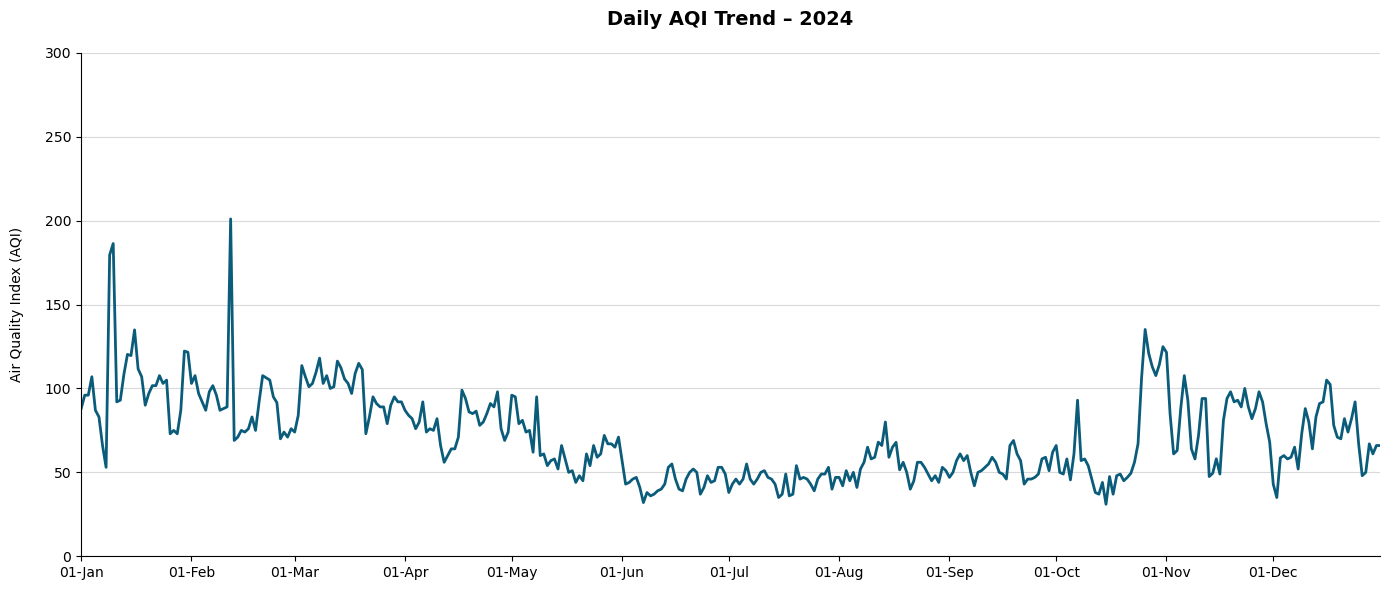

In [47]:
plt.figure(figsize=(14, 6))

# Daily AQI line
plt.plot(
    daily['date'],
    daily['final_aqi'],
    color='#0B5C7A',
    linewidth=2
)

# Titles & labels
plt.title(
    "Daily AQI Trend – 2024",
    fontsize=14,
    fontweight='bold',
    pad=20
)
plt.ylabel(
    "Air Quality Index (AQI)",
    labelpad=15
)

# Axis limits
plt.ylim(0, 300)
plt.xlim(
    daily['date'].min(),
    daily['date'].max()
)

# Grid (Excel-like)
plt.grid(
    axis='y',
    linestyle='-',
    color='#d9d9d9'
)

# Date formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Clean spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Final layout
plt.tight_layout()
plt.show()


In [48]:
aqi_order = ["Good","Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]

In [49]:
aqi_color_map = {
    "Good":         "#00E40080",
    "Satisfactory": "#00E40080",
    "Moderate":     "#FFFF0080",
    "Poor":         "#FF7E0080",
    "Very Poor":    "#FF000080",
    "Severe":       "#7E002380"
}

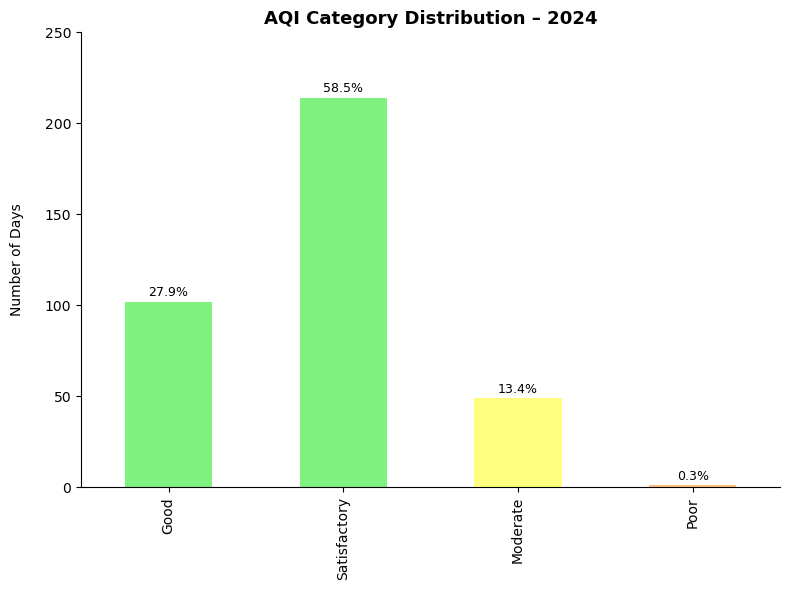

In [50]:
# AQI category counts (ordered)
cnt_ctgr = (
    daily['category']
    .value_counts()
    .reindex(aqi_order)
    .dropna()
)

# Color mapping for bars
colors = [aqi_color_map[cat] for cat in cnt_ctgr.index]

plt.figure(figsize=(8, 6))

# Bar chart
cnt_ctgr.plot(
    kind='bar',
    color=colors
)

# Titles & labels
plt.title(
    "AQI Category Distribution – 2024",
    fontsize=13,
    fontweight='bold'
)
plt.ylabel(
    "Number of Days",
    labelpad=15
)
plt.xlabel("")

# Axis limits
plt.ylim(0, 250)

# Percentage labels
total_days = cnt_ctgr.sum()

for i, v in enumerate(cnt_ctgr.values):
    percentage = (v / total_days) * 100
    plt.text(
        i,
        v + 3,
        f"{percentage:.1f}%",
        ha="center",
        fontsize=9
    )

# Clean spines (Excel-style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


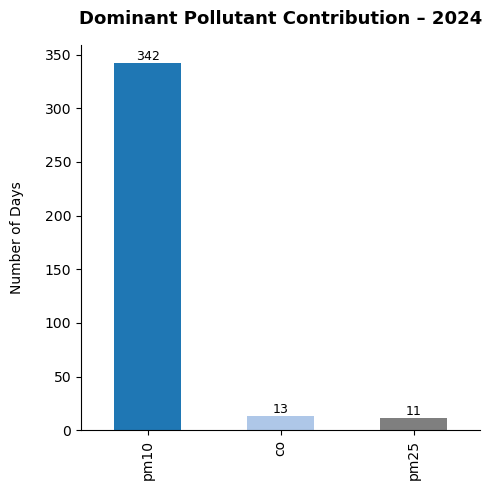

In [51]:
# Dominant pollutant counts
dom_cnt = daily['dominant_pollutant'].value_counts()

plt.figure(figsize=(5, 5))

# Bar chart
dom_cnt.plot(
    kind='bar',
    color=[
        '#1f77b4',  # PM10
        '#aec7e8',  # PM2.5
        '#7f7f7f',  # CO
        '#d9d9d9',  # NO2
        '#d9d9d9',  # SO2
        '#d9d9d9'   # O3
    ]
)

# Titles & labels
plt.title(
    'Dominant Pollutant Contribution – 2024',
    fontsize=13,
    fontweight='bold',
    pad = 15
)
plt.ylabel(
    'Number of Days',
    labelpad=15
)
plt.xlabel('')

# Value labels
for i, v in enumerate(dom_cnt.values):
    plt.text(
        i,
        v + 3,
        v,
        ha='center',
        fontsize=9
    )

# Clean spines (Excel-style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [53]:
top10 = daily.sort_values('final_aqi', ascending = False).head(10).copy()

In [54]:
top10['date_str'] = top10['date'].dt.strftime('%d-%b-%Y')

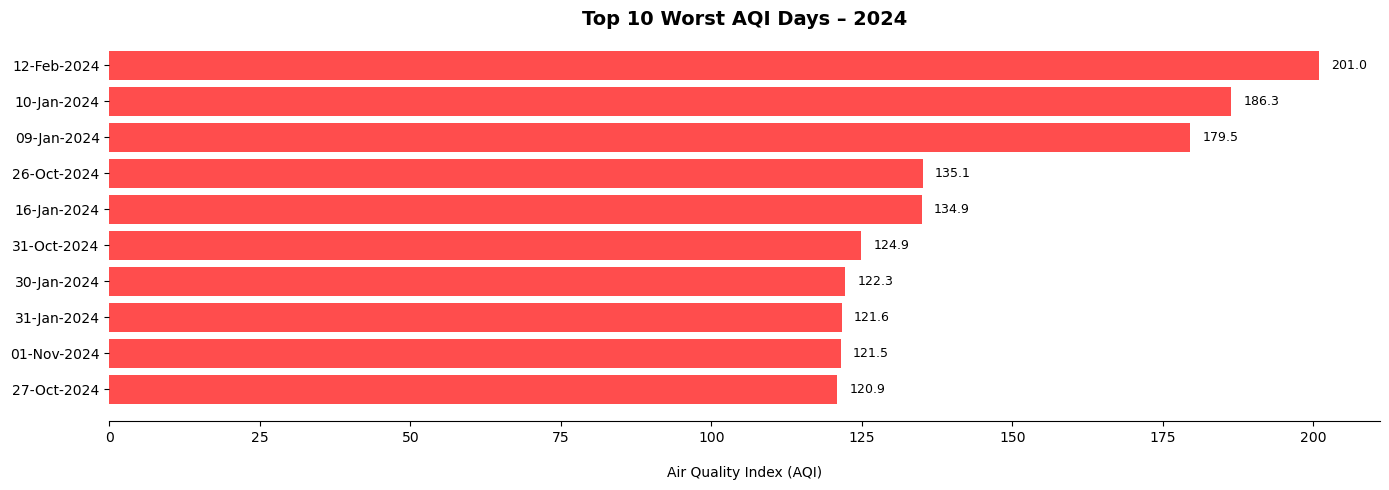

In [55]:
plt.figure(figsize=(14, 5))

# Horizontal bar chart
plt.barh(
    top10['date_str'],
    top10['final_aqi'],
    color='#FF4D4D'
)

# Show worst AQI on top
plt.gca().invert_yaxis()

# Titles & labels
plt.title(
    'Top 10 Worst AQI Days – 2024',
    fontsize=14,
    fontweight='bold'
)
plt.xlabel('Air Quality Index (AQI)',
          labelpad=15
)

# AQI value labels
for i, v in enumerate(top10['final_aqi']):
    plt.text(
        v + 2,
        i,
        f"{v:.1f}",
        va='center',
        fontsize=9
    )

# Clean spines (Excel-style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Layout & save
plt.tight_layout()
plt.savefig('top_10_worst_aqi_2024.png', dpi=300, bbox_inches='tight')
plt.show()


In [56]:
daily_cols = ['date', 'pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
monthly = daily[daily_cols].copy()

In [58]:
monthly.insert(monthly.columns.get_loc("date") + 1,"year", monthly["date"].dt.year) 

In [59]:
monthly.insert(monthly.columns.get_loc("year") + 1,"month", monthly["date"].dt.month)

In [60]:
monthly.insert( monthly.columns.get_loc("month") + 1,"month_name",pd.to_datetime(monthly["month"], format="%m").dt.month_name())

In [62]:
monthly.head()

,date,year,month,month_name,pm25,pm10,no2,so2,co,o3
0,2024-01-01,2024,1,January,42.00,87.77,18.07,7.96,0.69,43.72
1,2024-01-02,2024,1,January,44.89,95.90,18.04,7.48,0.74,41.10
2,2024-01-03,2024,1,January,43.80,96.15,18.10,7.74,0.68,42.70
3,2024-01-04,2024,1,January,47.99,110.06,18.28,7.77,0.82,36.61
4,2024-01-05,2024,1,January,38.07,87.13,17.63,7.56,0.74,35.74


In [63]:
monthly = (
    monthly
    .groupby(['year', 'month', 'month_name'], as_index=False)
    .mean(numeric_only=True)
)


In [66]:
monthly["aqi_pm25"] = monthly["pm25"].apply(lambda x : pollutant_aqi(round(x) , pm25_bp ))

In [67]:
monthly["aqi_pm10"] = monthly["pm10"].apply(lambda x : pollutant_aqi(round(x) , pm10_bp ))

In [68]:
monthly["aqi_no2"] = monthly["no2"].apply(lambda x : pollutant_aqi(round(x) , no2_bp ))

In [69]:
monthly["aqi_so2"] = monthly["so2"].apply(lambda x : pollutant_aqi(round(x) , so2_bp ))

In [70]:
monthly["aqi_co"] = monthly["co"].apply(lambda x : pollutant_aqi(round(x,2) , co_bp ))

In [71]:
monthly["aqi_o3"] = monthly["o3"].apply(lambda x : pollutant_aqi(round(x) , o3_bp ))

In [72]:
monthly.head()

,year,month,month_name,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3
0,2024,1,January,46.090968,98.732581,18.142903,8.023548,0.813548,38.888387,76.344828,99.0,22.50,10.00,40.5,39.0
1,2024,2,February,43.776552,87.976552,18.538966,8.404138,0.776207,39.562759,72.965517,88.0,23.75,10.00,39.0,40.0
2,2024,3,March,49.882903,100.463226,18.761613,9.251935,0.714194,46.836452,83.103448,100.0,23.75,11.25,35.5,47.0
3,2024,4,April,38.562667,79.239333,15.572667,8.362333,0.588333,41.784333,64.517241,79.0,20.00,10.00,29.5,42.0
4,2024,5,May,27.139677,64.583226,13.947419,7.980968,0.683871,41.623548,45.000000,65.0,17.50,10.00,34.0,42.0


In [73]:
monthly['final_aqi'] = monthly[aqi_cols].max(axis = 1)

In [74]:
monthly["category"] = monthly["final_aqi"].apply(aqi_category) 

In [75]:
monthly["dominant_pollutant"] = (
    monthly[aqi_cols]
    .idxmax(axis=1)
    .str.replace("aqi_", "")
)

In [76]:
monthly[all_cols] = monthly[all_cols].round(2)

In [77]:
monthly.head()

,year,month,month_name,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_no2,aqi_so2,aqi_co,aqi_o3,final_aqi,category,dominant_pollutant
0,2024,1,January,46.09,98.73,18.14,8.02,0.81,38.89,76.34,99.0,22.50,10.00,40.5,39.0,99.0,Satisfactory,pm10
1,2024,2,February,43.78,87.98,18.54,8.40,0.78,39.56,72.97,88.0,23.75,10.00,39.0,40.0,88.0,Satisfactory,pm10
2,2024,3,March,49.88,100.46,18.76,9.25,0.71,46.84,83.10,100.0,23.75,11.25,35.5,47.0,100.0,Satisfactory,pm10
3,2024,4,April,38.56,79.24,15.57,8.36,0.59,41.78,64.52,79.0,20.00,10.00,29.5,42.0,79.0,Satisfactory,pm10
4,2024,5,May,27.14,64.58,13.95,7.98,0.68,41.62,45.00,65.0,17.50,10.00,34.0,42.0,65.0,Satisfactory,pm10


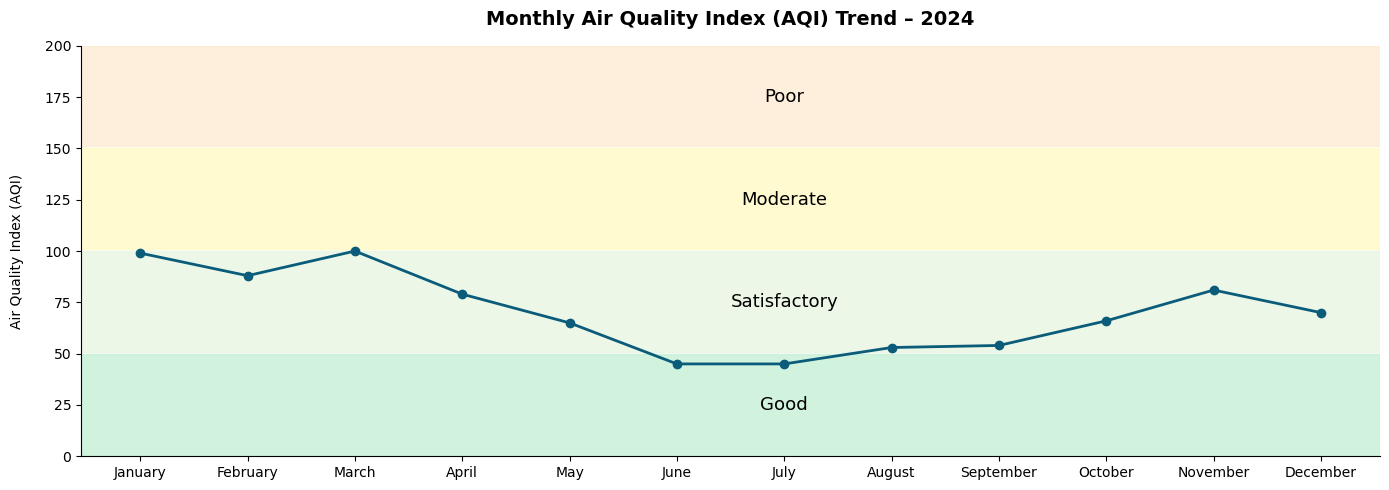

In [78]:
plt.figure(figsize=(14, 5))

# Data
month = monthly['month_name']
aqi = monthly['final_aqi']

# Monthly AQI line
plt.plot(
    month,
    aqi,
    marker='o',
    linewidth=2,
    color='#0B5C7A'
)

# Titles & labels
plt.title(
    'Monthly Air Quality Index (AQI) Trend – 2024',
    fontsize=14,
    fontweight='bold',
    pad=15
)
plt.ylabel(
    'Air Quality Index (AQI)',
    labelpad=15
)

# Axis limits
plt.ylim(0, 200)

# CPCB AQI background bands
plt.axhspan(0, 50,   color='#c6f1d6', alpha=0.8)   # Good
plt.axhspan(51, 100, color='#e8f5e1', alpha=0.8)   # Satisfactory
plt.axhspan(101, 150, color='#fff9c4', alpha=0.8)  # Moderate
plt.axhspan(151, 200, color='#fdebd3', alpha=0.8)  # Poor
plt.axhspan(201, 300, color='#f8c471', alpha=0.7)  # Very Poor
plt.axhspan(301, 500, color='#f1948a', alpha=0.7)  # Severe

# Category labels
plt.text(6, 25,  'Good',          ha='center', va='center', fontsize=13)
plt.text(6, 75,  'Satisfactory',  ha='center', va='center', fontsize=13)
plt.text(6, 125, 'Moderate',      ha='center', va='center', fontsize=13)
plt.text(6, 175, 'Poor',          ha='center', va='center', fontsize=13)

# Clean spines (Excel-style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Final layout
plt.tight_layout()
plt.show()